In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
df = pd.read_csv('heart_attack_dataset.csv')

In [138]:
# print(df.shape)
# print(df.head())
# categorization of columns for reference
BinaryColumns = ['Smoker', 'Diabetes', 'Hypertension', 'FamilyHistory', 
                 'PreviousHeartAttack', 'StrokeHistory']
    
ContinuousColumns = ['Age', 'Cholesterol', 'BloodPressure', 'HeartRate', 'BMI', 'PhysicalActivity', 'AlcoholConsumption',
                     'StressLevel', 'Income', 'MaxHeartRate', 'ST_Depression', 'NumberOfMajorVessels']
    
CategoricalColumns = ['Gender', 'Diet', 'Ethnicity', 'EducationLevel', 
                      'Medication', 'ChestPainType', 'ECGResults', 'Slope', 
                      'Thalassemia', 'Residence', 'EmploymentStatus', 
                      'MaritalStatus', 'ExerciseInducedAngina']

In [164]:
# extract features
binary_features = df[['PreviousHeartAttack', 'Diabetes', 'Smoker']].values
continuous_features = df[['Age', 'BloodPressure', 'Cholesterol', 'MaxHeartRate', 'BMI', 'NumberOfMajorVessels']].values
categorical_features = df[['ChestPainType', 'ECGResults', 'ST_Depression']]

# one-hot encode categorical features 
categorical_features = pd.get_dummies(categorical_features, drop_first=True).values

# normalize continuous features
# NOTE: THIS IS DATA LEAKAGE! the validation set is also getting scaled here, meaning the test data 
# is influences the scaling parameters, leading to overly optimistic performance metrics
# this should be done AFTER the split! keep for now
scaler = StandardScaler()
continuous_features = scaler.fit_transform(continuous_features)

# combine all features
X = np.concatenate([binary_features, continuous_features, categorical_features], axis=1)

In [165]:

# extract target
y = df['Outcome'].values
# convert 'heartk attack' and 'not heart attack' to binary output
y = (y == 'Heart Attack').astype(int)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32).view(-1, 1)

X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32).view(-1, 1)

In [166]:
# note: after one hot encoding, each category from each categorical feature becomes its own feature
# therefore, for example, 9 chosen columns could actually mean 14 columns
# remember that when creating the first NN layer!
print(X.shape)

(372974, 15)


In [170]:
# class NN(nn.Module):
#     def __init__(self):
#         super(NN, self).__init__()
#         self.fc1 = nn.Linear(12, 32) # input layer.  note: first input num must match number of input features
#         self.fc2 = nn.Linear(32, 16)
#         self.fc_out = nn.Linear(16, 1)  # last hidden layer to output layer
#         self.dropout = nn.Dropout(p=0.05)
    
#     def forward(self, x):
#         # ReLu on hidden layers
#         x = torch.relu(self.fc1(x)) 
#         x = self.dropout(x)
#         x = torch.relu(self.fc2(x))  
#         x = self.dropout(x)
#         #x = torch.relu(self.fc3(x))   
#         #x = torch.relu(self.fc5(x))   
#         x = self.fc_out(x) # sigmoid activiation on output
#         return x


class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(15, 128)  # Input layer
        self.bn1 = nn.BatchNorm1d(128)        # BatchNorm after first layer
        self.fc2 = nn.Linear(128, 64)         # Second hidden layer
        self.bn2 = nn.BatchNorm1d(64)         # BatchNorm after second layer
        self.fc3 = nn.Linear(64, 32)          # Third hidden layer
        self.bn3 = nn.BatchNorm1d(32)         # BatchNorm after third layer
        self.fc_out = nn.Linear(32, 1)        # Output layer
        self.dropout1 = nn.Dropout(p=0.5)     # Dropout after first layer
        self.dropout2 = nn.Dropout(p=0.3)     # Dropout after second layer

        # Initialize weights
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc_out.weight, nonlinearity='relu')

    def forward(self, x):
        # First hidden layer
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        
        # Second hidden layer
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        
        # Third hidden layer
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        
        # Output layer (no activation, since we're using BCEWithLogitsLoss)
        x = self.fc_out(x)
        return x

In [171]:
# hyper-parameters
learn_rate = 0.001
epochs = 20
batch_size = 128

In [178]:
# set GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# instantiate the model, move it to GPU
model = NN().to(device)

# loss function 
criterion = nn.BCEWithLogitsLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr = learn_rate)

# train loader for batch training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#TEST ON SIMPLE SET
X_train = X_train[:10]
y_train = y_train[:10]

# move training and testing data to GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

Using device: cuda


In [179]:
# training and validation
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


# batch training
# for epoch in range(epochs):
#     # Training phase
#     model.train()
#     for batch_X, batch_y in train_loader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()

for epoch in range(epochs):
    # training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Calculate training accuracy on the entire training set
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train)
        train_predictions = (train_outputs > 0.5).float()
        train_correct = (train_predictions == y_train).float().sum()
        train_accuracy = train_correct / y_train.shape[0]

    # Store training metrics
    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy.item())

    # Validation phase
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_predictions = (val_outputs > 0.5).float()
        val_correct = (val_predictions == y_test).float().sum()
        val_accuracy = val_correct / y_test.shape[0]

    # Store validation metrics
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    # Print metrics every few epochs
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy.item():.4f}, '
              f'Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy.item():.4f}')

Epoch [1/20], Training Loss: 0.8403, Training Accuracy: 0.8000, Validation Loss: 0.8807, Validation Accuracy: 0.4968
Epoch [2/20], Training Loss: 0.4604, Training Accuracy: 0.9000, Validation Loss: 0.8579, Validation Accuracy: 0.4982
Epoch [3/20], Training Loss: 0.4892, Training Accuracy: 0.9000, Validation Loss: 0.8266, Validation Accuracy: 0.4969
Epoch [4/20], Training Loss: 0.5874, Training Accuracy: 0.9000, Validation Loss: 0.8176, Validation Accuracy: 0.4974
Epoch [5/20], Training Loss: 0.5319, Training Accuracy: 0.9000, Validation Loss: 0.7931, Validation Accuracy: 0.4997
Epoch [6/20], Training Loss: 0.4660, Training Accuracy: 0.8000, Validation Loss: 0.7823, Validation Accuracy: 0.5005
Epoch [7/20], Training Loss: 0.7378, Training Accuracy: 0.9000, Validation Loss: 0.7853, Validation Accuracy: 0.4991
Epoch [8/20], Training Loss: 0.7651, Training Accuracy: 0.9000, Validation Loss: 0.7843, Validation Accuracy: 0.5000
Epoch [9/20], Training Loss: 0.3697, Training Accuracy: 0.8000, 

Maximum Training Accuracy: 1.0000
Maximum Validation Accuracy: 0.5013


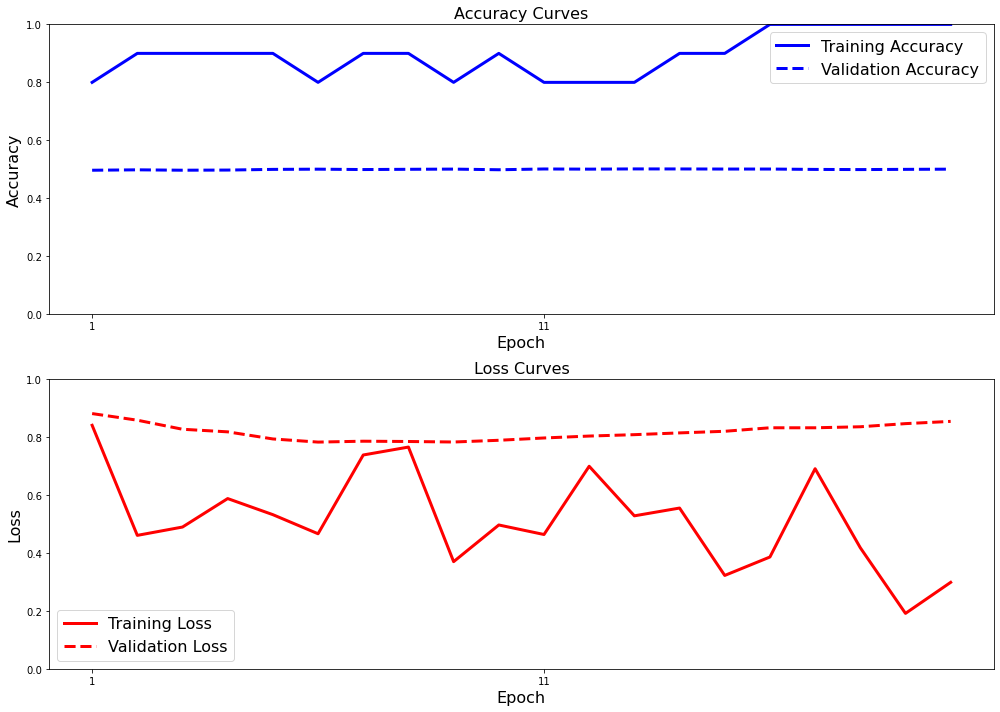

In [180]:
# max accuracies
print(f"Maximum Training Accuracy: {max(train_accuracies):.4f}")
print(f"Maximum Validation Accuracy: {max(val_accuracies):.4f}")

# accuracy curves
plt.figure(figsize=[14, 10])
plt.subplot(2, 1, 1) # note: divides output into 2 rows, 1 col, and this figure has position 1
plt.plot(train_accuracies, 'b', linewidth=3.0, label='Training Accuracy')
plt.plot(val_accuracies, 'b--', linewidth=3.0, label='Validation Accuracy')
plt.legend(fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(0, 1)
plt.xticks(np.arange(0, epochs, 10), np.arange(1, epochs + 1, 10))
plt.title('Accuracy Curves', fontsize=16)

# loss curves
plt.subplot(2, 1, 2)
plt.plot(train_losses, 'r', linewidth=3.0, label='Training Loss')
plt.plot(val_losses, 'r--', linewidth=3.0, label='Validation Loss')
plt.legend(fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim(0, 1)
plt.xticks(np.arange(0, epochs, 10), np.arange(1, epochs + 1, 10))
plt.title('Loss Curves', fontsize=16)

plt.tight_layout()
plt.show()